In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
%matplotlib inline

In [ ]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)[0]
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


### Definition of Action Space

In [ ]:
action_space = [0, 1, 2, 3]   #[UP, DOWN, LEFT, RIGHT]

### Exploration Strategies
 1. Epsilon - greedy
 2. Softmax

In [ ]:
seed = 42
rg = np.random.RandomState(seed)

# Epsilon - greedy
def choose_action_epsilon_greedy(Q, state, epsilon): #state must be an array of riw_index and column_index
  if not Q[state[0], state[1]].any() or rg.rand() < epsilon:
    return rg.choice(action_space, size = (1, ))[0]
  else:
    return np.argmax(Q[state[0], state[1]])

# Softmax
def choose_action_softmax(Q, state, tau):
  p = [None for _ in range(len(action_space))]
  for i in range(len(action_space)):
    p[i] = np.exp((Q[state[0], state[1], i]) / tau)
  p /= np.sum(p)
  return rg.choice(action_space, size = (1, ), p = p)[0]

### SARSA Algorithm Definition


In [ ]:
def sarsa(gw, Q, tau0, epsilon0, alpha0, gamma0, episodes = 10000, choose_action = choose_action_softmax):

  episode_rewards = np.zeros(episodes)
  steps_to_completion = np.zeros(episodes)
  state_visit_count = np.zeros((gw.num_rows, gw.num_cols))

  parameter = tau0
  alpha = alpha0
  gamma = gamma0
  if choose_action == choose_action_epsilon_greedy:
    parameter = epsilon0

  for ep in tqdm(range(episodes)):
    tot_reward, steps = 0, 0

    state = gw.reset()
    state_rc = seq_to_col_row(state, gw.num_cols)[0]
    action = choose_action(Q, state_rc, parameter)
    done = False
    while not done:

      if any(np.array_equal(state_rc, state) for state in gw.goal_states) or steps >= 100:
        done = True
        break

      next_state, reward = gw.step(state, action)
      reward = reward[0]
      next_state_rc = seq_to_col_row(next_state, gw.num_cols)[0]

      next_action = choose_action(Q, next_state_rc, parameter)
      Q[state_rc[0], state_rc[1],  action] += alpha * (reward + gamma * Q[next_state_rc[0], next_state_rc[1], next_action] - Q[state_rc[0], state_rc[1],  action])

      state_visit_count[state_rc[0], state_rc[1]] += 1
      tot_reward += reward
      steps += 1


      state, state_rc, action = next_state, next_state_rc, next_action



    episode_rewards[ep] = tot_reward
    steps_to_completion[ep] = steps
  return Q, episode_rewards, steps_to_completion, state_visit_count

### Q Learning Algorithm Definition

In [ ]:
def qlearning(gw, Q, tau0, epsilon0, alpha0, gamma0, episodes = 10000, choose_action = choose_action_softmax):

  episode_rewards = np.zeros(episodes)
  steps_to_completion = np.zeros(episodes)
  state_visit_count = np.zeros((gw.num_rows, gw.num_cols))

  parameter = tau0
  alpha = alpha0
  gamma = gamma0
  if choose_action == choose_action_epsilon_greedy:
    parameter = epsilon0

  for ep in tqdm(range(episodes)):
    tot_reward, steps = 0, 0

    state = gw.reset()
    state_rc = seq_to_col_row(state, gw.num_cols)[0]
    action = choose_action(Q, state_rc, parameter)
    done = False
    while not done:

      if any(np.array_equal(state_rc, state) for state in gw.goal_states) or steps >= 100:
        done = True
        break

      next_state, reward = gw.step(state, action)
      reward = reward[0]
      next_state_rc = seq_to_col_row(next_state, gw.num_cols)[0]

      next_action = choose_action(Q, next_state_rc, parameter)
      Q[state_rc[0], state_rc[1],  action] += alpha * (reward + gamma * max(Q[next_state_rc[0], next_state_rc[1]]) - Q[state_rc[0], state_rc[1],  action])

      state_visit_count[state_rc[0], state_rc[1]] += 1
      tot_reward += reward
      steps += 1


      state, state_rc, action = next_state, next_state_rc, next_action



    episode_rewards[ep] = tot_reward
    steps_to_completion[ep] = steps
  return Q, episode_rewards, steps_to_completion, state_visit_count

### Plot_Q function :
 For plotting the Heat map of Q values given the Q (action state value funtion)

In [ ]:
import seaborn

In [ ]:
def plot_Q(Q, rewards, message):
  seaborn.heatmap(Q.max(-1))
  policy = Q.argmax(-1)
  for i in range(policy.shape[0]):
    for j in range(policy.shape[1]):
      action = policy[i, j]
      if action == 0:  # Up
        plt.arrow(j + 0.5, i + 0.8, 0, - 0.4, head_width = 0.1, head_length = 0.1, fc = 'blue', ec = 'blue')
      elif action == 1:  # Down
        plt.arrow(j + 0.5, i + 0.2, 0, 0.4, head_width = 0.1, head_length = 0.1, fc = 'blue', ec = 'blue')
      elif action == 2:  # Left
        plt.arrow(j + 0.8, i + 0.5, - 0.4, 0, head_width = 0.1, head_length = 0.1, fc = 'blue', ec = 'blue')
      elif action == 3:  # Right
        plt.arrow(j + 0.2, i + 0.5, 0.4, 0, head_width = 0.1, head_length = 0.1, fc = 'blue', ec = 'blue')

  plt.title(f"Heat map of the grid with Q for policy : {message}, Average_Reward : %f, Qmax : %.2f, Qmin : %.2f" % ((np.mean(rewards), Q.max(), Q.min())))

  plt.show()

### Plot_SVC function :    
For plotting the Heat map of state visit count

In [ ]:
def plot_SVC(SVC, message):
  seaborn.heatmap(SVC)
  for i in range(len(SVC)):
    for j in range(len(SVC[i])):
      plt.text(j + 0.5, i + 0.5, f"{SVC[i][j]:.0f}", ha = 'center', va = 'center', color = 'white')
  plt.title(f"Heat map of the grid with State visit count for policy : {message}")
  plt.show()

### plot_RC :         
For plotting Reward curves

In [ ]:
def plot_RC(rewards, message, num_episodes = 10000):
  mean_rewards = np.mean(rewards, axis = 0)
  std_rewards = np.std(rewards, axis = 0)
  episodes = [i for i in range(num_episodes)]

  plt.figure()
  plt.plot(episodes, mean_rewards, color = 'blue')
  plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, color = 'Magenta')
  plt.xlabel("Episodes")
  plt.ylabel("Rewards Averaged over 5 runs")
  plt.title(f"Rewards vs Episodes for policy : {message}")
  plt.show()

### plot_STEP :          
For plotting Steps

In [ ]:
def plot_STEP(steps, message, num_episodes = 10000):
  mean_steps = np.mean(steps, axis = 0)
  std_steps = np.std(steps, axis = 0)
  episodes = [i for i in range(num_episodes)]

  plt.figure()
  plt.plot(episodes, mean_steps, color = 'blue')
  plt.fill_between(episodes, mean_steps - std_steps, mean_steps + std_steps, color = 'Magenta')
  plt.xlabel("Episodes")
  plt.ylabel("No of steps Averaged over 5 runs")
  plt.title(f"Steps vs Episodes for policy : {message}")
  plt.show()

### Defining of Experiment Environment

In [ ]:
def experiment(gw, tau, epsilon, alpha, gamma, choose_action = choose_action_softmax, num_expts = 5, algorithm = sarsa):
  if algorithm == qlearning:
    print("The algorithm being applied is : Q LEARNING")
  else:
    print("The algorithm being applied is : SARSA")
  if choose_action == choose_action_epsilon_greedy:
    print("The policy being applied is Epsilon greedy")
  else:
    print("The policy being applied is Softmax")
  reward_per_exp, steps_per_exp = [], []
  overall_Q = None
  overall_state_count = None
  for i in range(num_expts):
    print("Experiment : %d" % (i + 1))
    Q = np.zeros((gw.num_rows, gw.num_cols, len(action_space)))

    Q, rewards, steps, state_count = algorithm(gw, Q, tau, epsilon, alpha, gamma, episodes = 10000, choose_action = choose_action)
    reward_per_exp.append(rewards)
    steps_per_exp.append(steps)
    if overall_Q is None:
      overall_Q = Q
    else:
      overall_Q += Q
    if overall_state_count is None:
        overall_state_count = state_count
    else:
        overall_state_count += state_count
  avg_Q = overall_Q / 5
  avg_state_count = overall_state_count / 5
  return avg_Q, avg_state_count, reward_per_exp, steps_per_exp

### Start of 12 Experiments :                
Basic Information

In [ ]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],              #All obstruction states
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])                           #All bad states
restart_states = np.array([[3,7],[8,2]])                                         #All restart states
goal_states = np.array([[0,9],[2,2],[8,7]])

### 1st Experiment : SARSA
 - Start state : (0, 4)
 - wind : False
 - p = 1.0

In [ ]:
start_state = np.array([[0, 4]])
# create model
gw1 = GridWorld(num_rows = num_rows, num_cols = num_cols, start_state = start_state, goal_states = goal_states, wind = False)
gw1.add_obstructions(obstructed_states = obstructions, bad_states = bad_states, restart_states = restart_states)
gw1.add_rewards(step_reward = - 1, goal_reward = 10, bad_state_reward = - 6, restart_state_reward = - 100)
gw1.add_transition_probability(p_good_transition = 1.0, bias = 0.5)
env1 = gw1.create_gridworld()

#Defining parameters
tau1 = 1.0
epsilon1 = 0.01
alpha_tau1 = 0.1
gamma_tau1 = 1.0
alpha_epsilon1 = 0.2
gamma_epsilon1 = 1.0

In [ ]:
avg_Q_epsilon1, avg_state_count_epsilon1, rewards_per_exp_epsilon1, steps_per_exp_epsilon1 = experiment(gw1, tau1, epsilon1, alpha_epsilon1, gamma_epsilon1, choose_action = choose_action_epsilon_greedy, num_expts = 5)

The algorithm being applied is : SARSA
The policy being applied is Epsilon greedy
Experiment : 1


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1528.49it/s]


Experiment : 2


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1657.24it/s]


Experiment : 3


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1427.35it/s]


Experiment : 4


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1514.00it/s]


Experiment : 5


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1087.07it/s]


In [ ]:
avg_Q_tau1, avg_state_count_tau1, rewards_per_exp_tau1, steps_per_exp_tau1 = experiment(gw1, tau1, epsilon1, alpha_tau1, gamma_tau1, num_expts = 5)

The algorithm being applied is : SARSA
The policy being applied is Softmax
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 501.11it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 534.82it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 553.17it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 603.18it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 620.59it/s]


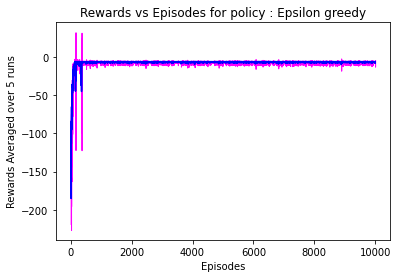

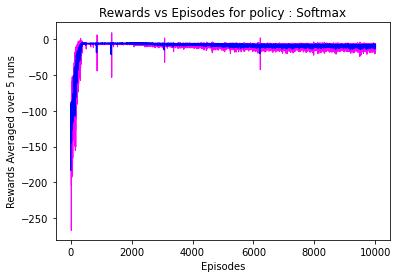

In [ ]:
plot_RC(rewards_per_exp_epsilon1, message = "Epsilon greedy")
plot_RC(rewards_per_exp_tau1, message = "Softmax")

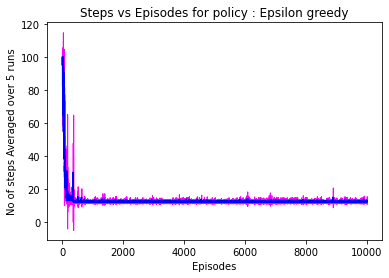

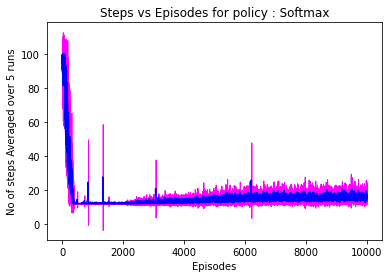

In [ ]:
plot_STEP(steps_per_exp_epsilon1, message = "Epsilon greedy")
plot_STEP(steps_per_exp_tau1, message = "Softmax")

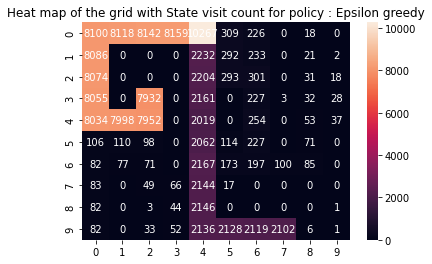

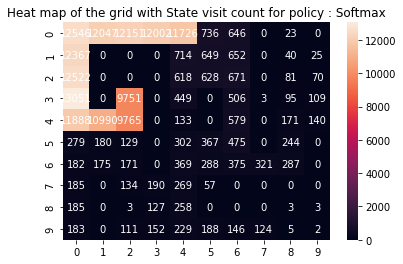

In [ ]:
plot_SVC(avg_state_count_epsilon1, message = "Epsilon greedy")
plot_SVC(avg_state_count_tau1, message = "Softmax")

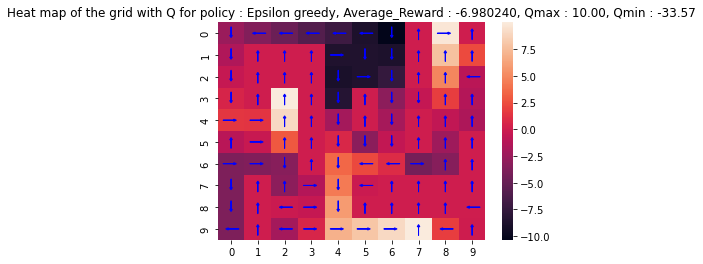

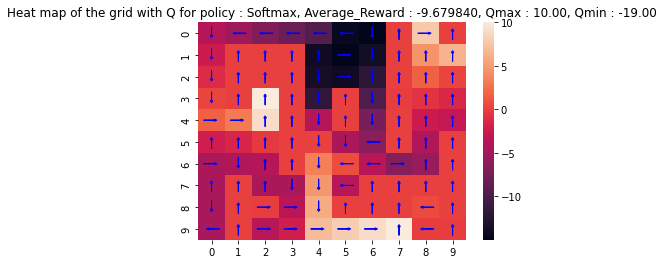

In [ ]:
plot_Q(avg_Q_epsilon1, rewards_per_exp_epsilon1, message = "Epsilon greedy")
plot_Q(avg_Q_tau1, rewards_per_exp_tau1, message = "Softmax")

### 2nd Experiment : SARSA
 - Start state : (0, 4)
 - wind : False
 - p = 0.7

In [ ]:
start_state = np.array([[0, 4]])
# create model
gw2 = GridWorld(num_rows = num_rows, num_cols = num_cols, start_state = start_state, goal_states = goal_states, wind = False)
gw2.add_obstructions(obstructed_states = obstructions, bad_states = bad_states, restart_states = restart_states)
gw2.add_rewards(step_reward = - 1, goal_reward = 10, bad_state_reward = - 6, restart_state_reward = - 100)
gw2.add_transition_probability(p_good_transition = 0.7, bias = 0.5)
env2 = gw2.create_gridworld()

#Defining parameters
tau2 = 1.0
epsilon2 = 0.01
alpha_tau2 = 0.2
gamma_tau2 = 1.0
alpha_epsilon2 = 0.2
gamma_epsilon2 = 1.0

In [ ]:
avg_Q_epsilon2, avg_state_count_epsilon2, rewards_per_exp_epsilon2, steps_per_exp_epsilon2 = experiment(gw2, tau2, epsilon2, alpha_epsilon2, gamma_epsilon2, choose_action = choose_action_epsilon_greedy, num_expts = 5)

The algorithm being applied is : SARSA
The policy being applied is Epsilon greedy
Experiment : 1


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1069.86it/s]


Experiment : 2


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1049.10it/s]


Experiment : 3


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1087.23it/s]


Experiment : 4


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1070.33it/s]


Experiment : 5


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1048.11it/s]


In [ ]:
avg_Q_tau2, avg_state_count_tau2, rewards_per_exp_tau2, steps_per_exp_tau2 = experiment(gw2, tau2, epsilon2, alpha_tau2, gamma_tau2, num_expts = 5)

The algorithm being applied is : SARSA
The policy being applied is Softmax
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.49it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.91it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.51it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 370.00it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.93it/s]


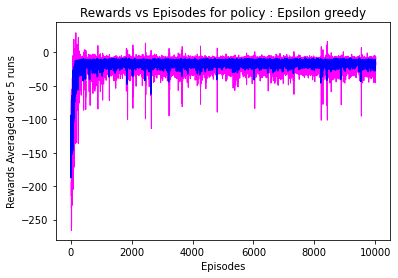

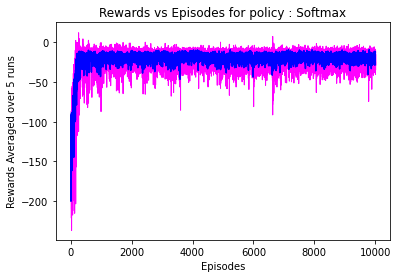

In [ ]:
plot_RC(rewards_per_exp_epsilon2, message = "Epsilon greedy")
plot_RC(rewards_per_exp_tau2, message = "Softmax")

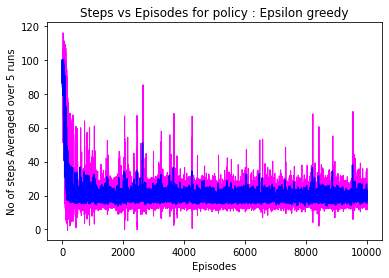

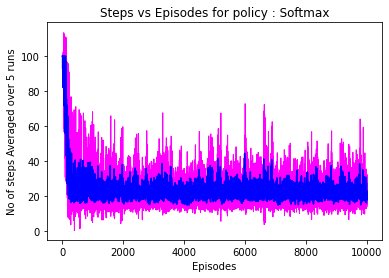

In [ ]:
plot_STEP(steps_per_exp_epsilon2, message = "Epsilon greedy")
plot_STEP(steps_per_exp_tau2, message = "Softmax")

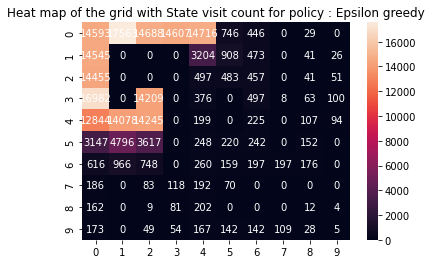

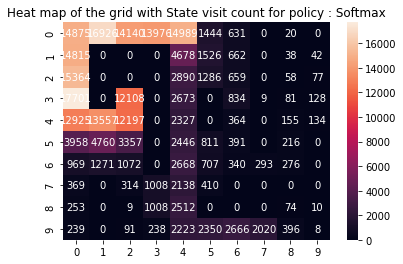

In [ ]:
plot_SVC(avg_state_count_epsilon2, message = "Epsilon greedy")
plot_SVC(avg_state_count_tau2, message = "Softmax")

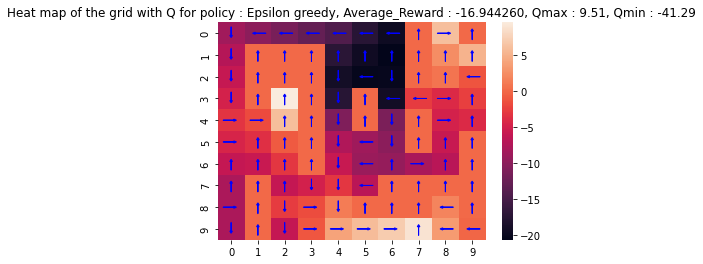

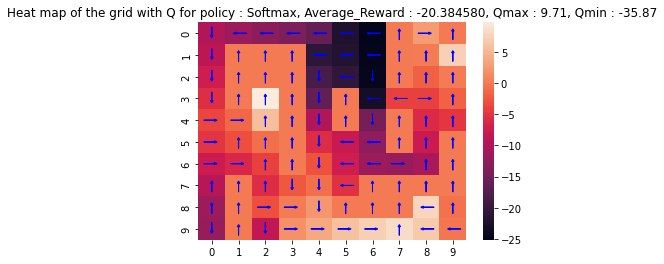

In [ ]:
plot_Q(avg_Q_epsilon2, rewards_per_exp_epsilon2, message = "Epsilon greedy")
plot_Q(avg_Q_tau2, rewards_per_exp_tau2, message = "Softmax")

### 3rd Experiment : SARSA
 - Start state : (0, 4)
 - wind : True
 - p = 1.0

In [ ]:
start_state = np.array([[0, 4]])
# create model
gw3 = GridWorld(num_rows = num_rows, num_cols = num_cols, start_state = start_state, goal_states = goal_states, wind = True)
gw3.add_obstructions(obstructed_states = obstructions, bad_states = bad_states, restart_states = restart_states)
gw3.add_rewards(step_reward = - 1, goal_reward = 10, bad_state_reward = - 6, restart_state_reward = - 100)
gw3.add_transition_probability(p_good_transition = 1.0, bias = 0.5)
env3 = gw3.create_gridworld()

#Defining parameters
tau3 = 1.0
epsilon3 = 0.01
alpha_tau3 = 0.2
gamma_tau3 = 1.0
alpha_epsilon3 = 0.2
gamma_epsilon3 = 0.9

In [ ]:
avg_Q_epsilon3, avg_state_count_epsilon3, rewards_per_exp_epsilon3, steps_per_exp_epsilon3 = experiment(gw3, tau3, epsilon3, alpha_epsilon3, gamma_epsilon3, choose_action = choose_action_epsilon_greedy, num_expts = 5)

The algorithm being applied is : SARSA
The policy being applied is Epsilon greedy
Experiment : 1


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.55it/s]


Experiment : 2


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1331.64it/s]


Experiment : 3


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.48it/s]


Experiment : 4


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1334.79it/s]


Experiment : 5


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1316.71it/s]


In [ ]:
avg_Q_tau3, avg_state_count_tau3, rewards_per_exp_tau3, steps_per_exp_tau3 = experiment(gw3, tau3, epsilon3, alpha_tau3, gamma_tau3, num_expts = 5)

The algorithm being applied is : SARSA
The policy being applied is Softmax
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 464.99it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 470.74it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 467.02it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 470.23it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 471.96it/s]


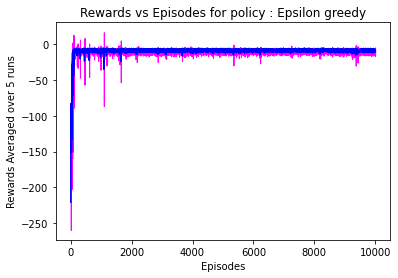

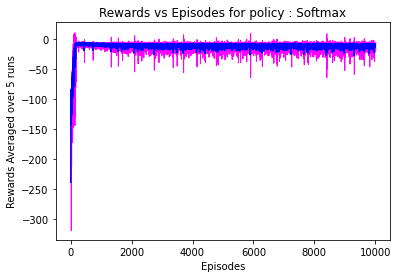

In [ ]:
plot_RC(rewards_per_exp_epsilon3, message = "Epsilon greedy")
plot_RC(rewards_per_exp_tau3, message = "Softmax")

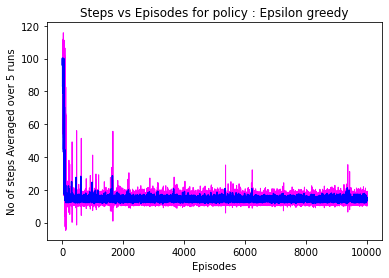

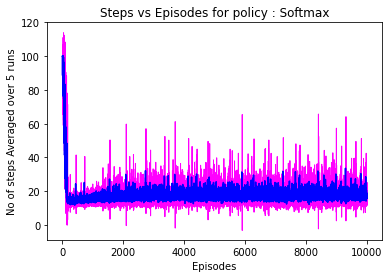

In [ ]:
plot_STEP(steps_per_exp_epsilon3, message = "Epsilon greedy")
plot_STEP(steps_per_exp_tau3, message = "Softmax")

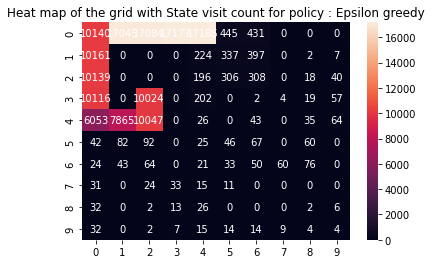

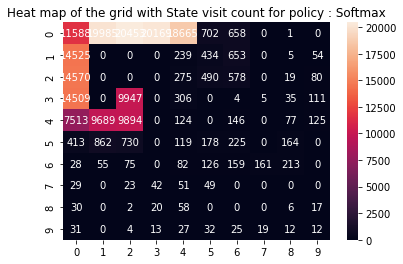

In [ ]:
plot_SVC(avg_state_count_epsilon3, message = "Epsilon greedy")
plot_SVC(avg_state_count_tau3, message = "Softmax")

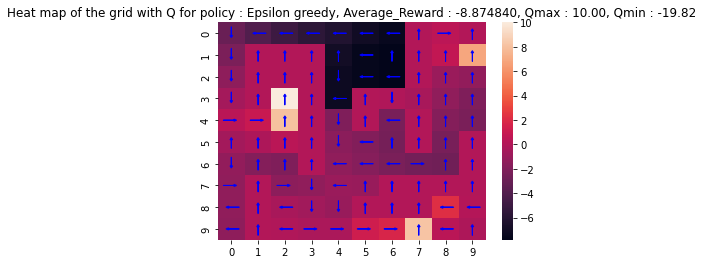

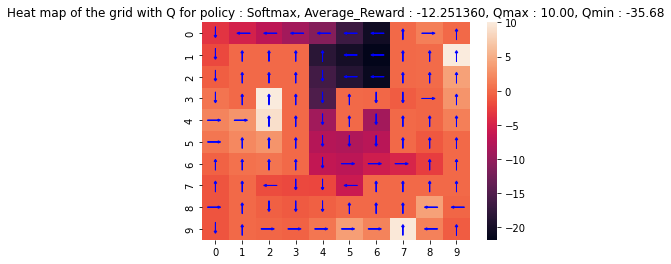

In [ ]:
plot_Q(avg_Q_epsilon3, rewards_per_exp_epsilon3, message = "Epsilon greedy")
plot_Q(avg_Q_tau3, rewards_per_exp_tau3, message = "Softmax")

### 4th Experiment : SARSA
 - Start state : (3, 6)
 - wind : False
 - p = 1.0

In [ ]:
start_state2 = np.array([[3, 6]])
# create model
gw4 = GridWorld(num_rows = num_rows, num_cols = num_cols, start_state = start_state2, goal_states = goal_states, wind = False)
gw4.add_obstructions(obstructed_states = obstructions, bad_states = bad_states, restart_states = restart_states)
gw4.add_rewards(step_reward = - 1, goal_reward = 10, bad_state_reward = - 6, restart_state_reward = - 100)
gw4.add_transition_probability(p_good_transition = 1.0, bias = 0.5)
env4 = gw4.create_gridworld()

#Defining parameters
tau4 = 1.0
epsilon4 = 0.01
alpha_tau4 = 0.2
gamma_tau4 = 1.0
alpha_epsilon4 = 0.2
gamma_epsilon4 = 1.0

In [ ]:
avg_Q_epsilon4, avg_state_count_epsilon4, rewards_per_exp_epsilon4, steps_per_exp_epsilon4 = experiment(gw4, tau4, epsilon4, alpha_epsilon4, gamma_epsilon4, choose_action = choose_action_epsilon_greedy, num_expts = 5)

The algorithm being applied is : SARSA
The policy being applied is Epsilon greedy
Experiment : 1


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1206.56it/s]


Experiment : 2


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1185.45it/s]


Experiment : 3


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1189.39it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 751.54it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 957.30it/s]


In [ ]:
avg_Q_tau4, avg_state_count_tau4, rewards_per_exp_tau4, steps_per_exp_tau4 = experiment(gw4, tau4, epsilon4, alpha_tau4, gamma_tau4, num_expts = 5)

The algorithm being applied is : SARSA
The policy being applied is Softmax
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 455.11it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 468.85it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 459.02it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 484.70it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 465.98it/s]


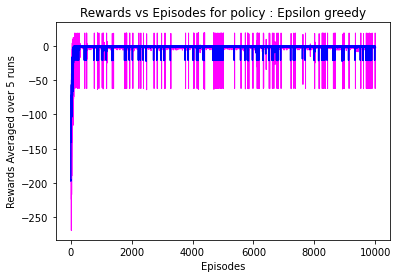

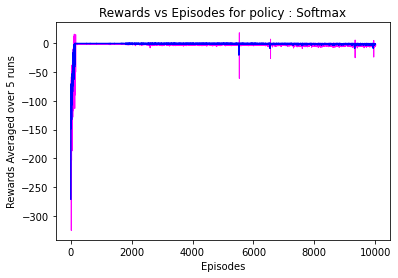

In [ ]:
plot_RC(rewards_per_exp_epsilon4, message = "Epsilon greedy")
plot_RC(rewards_per_exp_tau4, message = "Softmax")

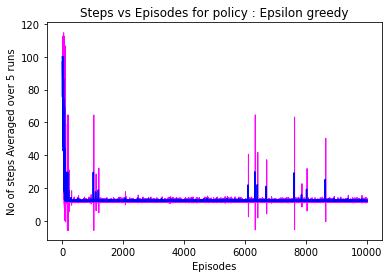

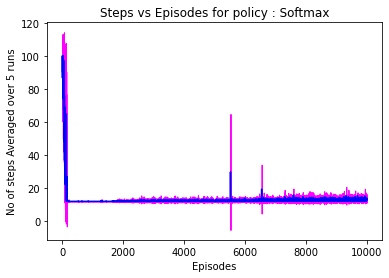

In [ ]:
plot_STEP(steps_per_exp_epsilon4, message = "Epsilon greedy")
plot_STEP(steps_per_exp_tau4, message = "Softmax")

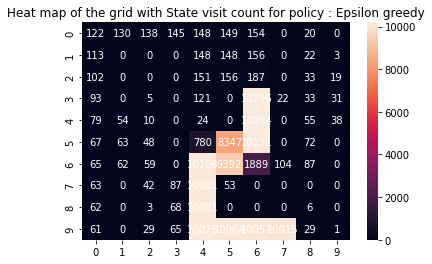

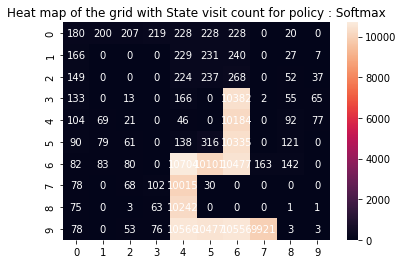

In [ ]:
plot_SVC(avg_state_count_epsilon4, message = "Epsilon greedy")
plot_SVC(avg_state_count_tau4, message = "Softmax")

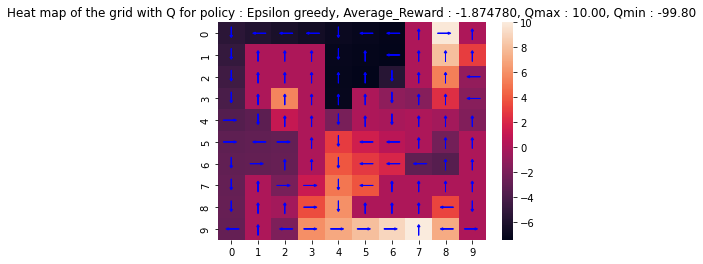

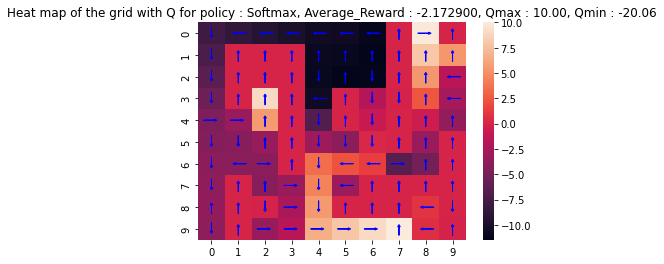

In [ ]:
plot_Q(avg_Q_epsilon4, rewards_per_exp_epsilon4, message = "Epsilon greedy")
plot_Q(avg_Q_tau4, rewards_per_exp_tau4, message = "Softmax")

### 5th Experiment : SARSA
 - Start state : (3, 6)
 - wind : False
 - p = 0.7

In [ ]:
start_state2 = np.array([[3, 6]])
# create model
gw5 = GridWorld(num_rows = num_rows, num_cols = num_cols, start_state = start_state2, goal_states = goal_states, wind = False)
gw5.add_obstructions(obstructed_states = obstructions, bad_states = bad_states, restart_states = restart_states)
gw5.add_rewards(step_reward = - 1, goal_reward = 10, bad_state_reward = - 6, restart_state_reward = - 100)
gw5.add_transition_probability(p_good_transition = 0.7, bias = 0.5)
env5 = gw5.create_gridworld()

#Defining parameters
tau5 = 1.0
epsilon5 = 0.01
alpha_tau5 = 0.2
gamma_tau5 = 1.0
alpha_epsilon5 = 0.1
gamma_epsilon5 = 1.0

In [ ]:
avg_Q_epsilon5, avg_state_count_epsilon5, rewards_per_exp_epsilon5, steps_per_exp_epsilon5 = experiment(gw5, tau5, epsilon5, alpha_epsilon5, gamma_epsilon5, choose_action = choose_action_epsilon_greedy, num_expts = 5)

The algorithm being applied is : SARSA
The policy being applied is Epsilon greedy
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 600.04it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 661.25it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 755.11it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 700.65it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 732.38it/s]


In [ ]:
avg_Q_tau5, avg_state_count_tau5, rewards_per_exp_tau5, steps_per_exp_tau5 = experiment(gw5, tau5, epsilon5, alpha_tau5, gamma_tau5, num_expts = 5)

The algorithm being applied is : SARSA
The policy being applied is Softmax
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 281.01it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 292.83it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 290.60it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 288.12it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 292.22it/s]


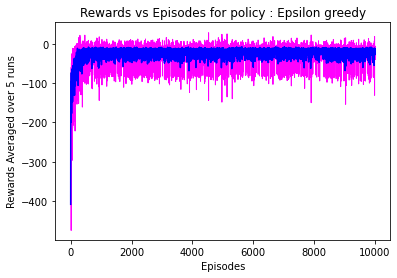

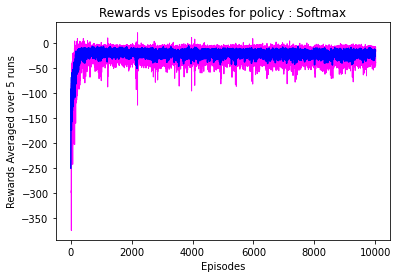

In [ ]:
plot_RC(rewards_per_exp_epsilon5, message = "Epsilon greedy")
plot_RC(rewards_per_exp_tau5, message = "Softmax")

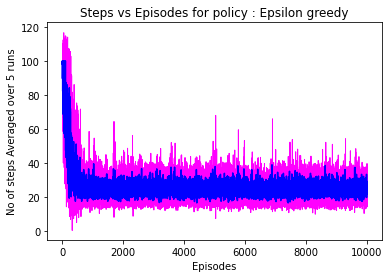

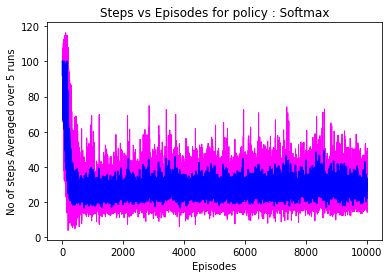

In [ ]:
plot_STEP(steps_per_exp_epsilon5, message = "Epsilon greedy")
plot_STEP(steps_per_exp_tau5, message = "Softmax")

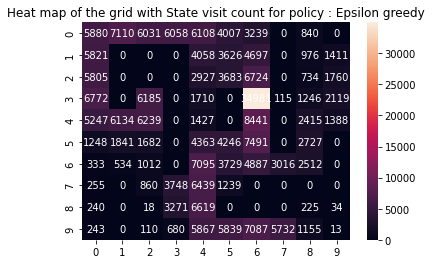

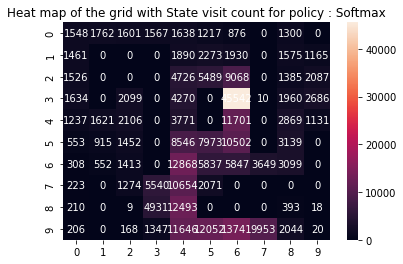

In [ ]:
plot_SVC(avg_state_count_epsilon5, message = "Epsilon greedy")
plot_SVC(avg_state_count_tau5, message = "Softmax")

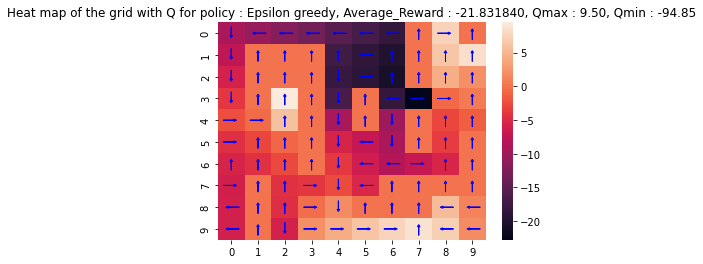

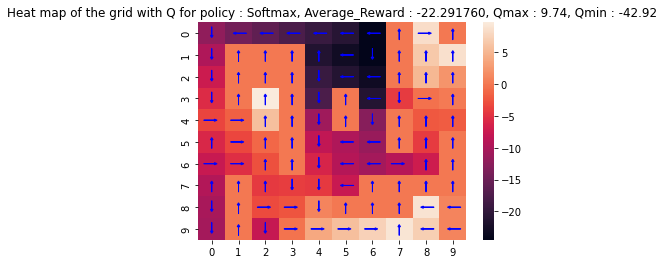

In [ ]:
plot_Q(avg_Q_epsilon5, rewards_per_exp_epsilon5, message = "Epsilon greedy")
plot_Q(avg_Q_tau5, rewards_per_exp_tau5, message = "Softmax")

### 6th Experiment : SARSA
 - Start state : (3, 6)
 - wind : True
 - p = 1.0

In [ ]:
start_state2 = np.array([[3, 6]])
# create model
gw6 = GridWorld(num_rows = num_rows, num_cols = num_cols, start_state = start_state2, goal_states = goal_states, wind = True)
gw6.add_obstructions(obstructed_states = obstructions, bad_states = bad_states, restart_states = restart_states)
gw6.add_rewards(step_reward = - 1, goal_reward = 10, bad_state_reward = - 6, restart_state_reward = - 100)
gw6.add_transition_probability(p_good_transition = 1.0, bias = 0.5)
env6 = gw6.create_gridworld()

#Defining parameters
tau6 = 1.0
epsilon6 = 0.01
alpha_tau6 = 0.2
gamma_tau6 = 1.0
alpha_epsilon6 = 0.1
gamma_epsilon6 = 1.0

In [ ]:
avg_Q_epsilon6, avg_state_count_epsilon6, rewards_per_exp_epsilon6, steps_per_exp_epsilon6 = experiment(gw6, tau6, epsilon6, alpha_epsilon6, gamma_epsilon6, choose_action = choose_action_epsilon_greedy, num_expts = 5)

The algorithm being applied is : SARSA
The policy being applied is Epsilon greedy
Experiment : 1


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1332.37it/s]


Experiment : 2


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.18it/s]


Experiment : 3


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1359.62it/s]


Experiment : 4


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.45it/s]


Experiment : 5


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.00it/s]


In [ ]:
avg_Q_tau6, avg_state_count_tau6, rewards_per_exp_tau6, steps_per_exp_tau6 = experiment(gw6, tau6, epsilon6, alpha_tau6, gamma_tau6, num_expts = 5)

The algorithm being applied is : SARSA
The policy being applied is Softmax
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 508.73it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 525.88it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 521.31it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 534.89it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 527.26it/s]


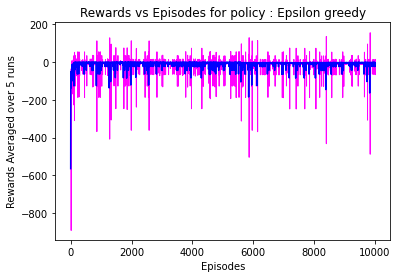

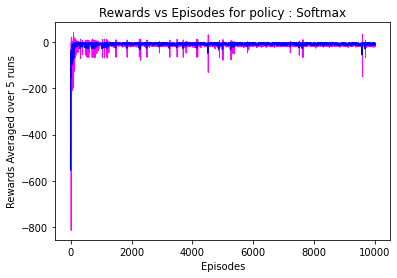

In [ ]:
plot_RC(rewards_per_exp_epsilon6, message = "Epsilon greedy")
plot_RC(rewards_per_exp_tau6, message = "Softmax")

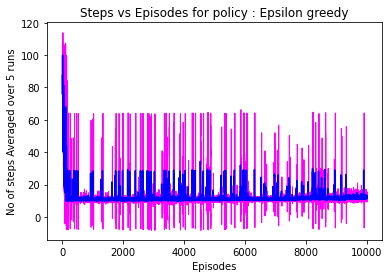

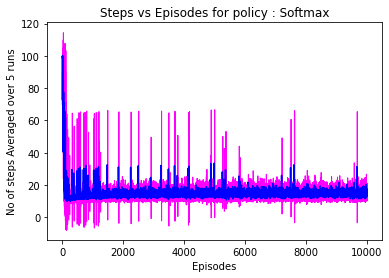

In [ ]:
plot_STEP(steps_per_exp_epsilon6, message = "Epsilon greedy")
plot_STEP(steps_per_exp_tau6, message = "Softmax")

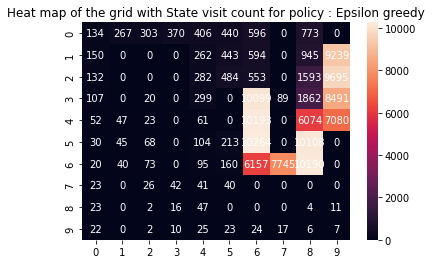

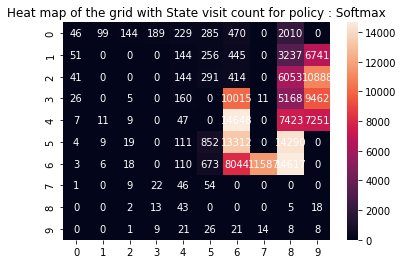

In [ ]:
plot_SVC(avg_state_count_epsilon6, message = "Epsilon greedy")
plot_SVC(avg_state_count_tau6, message = "Softmax")

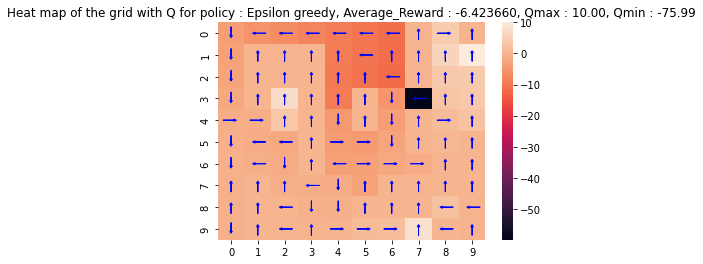

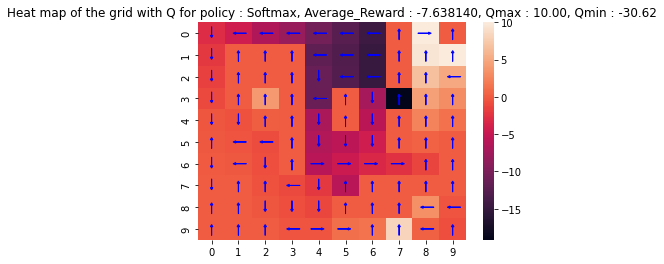

In [ ]:
plot_Q(avg_Q_epsilon6, rewards_per_exp_epsilon6, message = "Epsilon greedy")
plot_Q(avg_Q_tau6, rewards_per_exp_tau6, message = "Softmax")

### 7th Experiment : Q LEARNING
 - Start state : (0, 4)
 - wind : False
 - p = 1.0

In [ ]:
start_state = np.array([[0, 4]])
# create model
gw7 = GridWorld(num_rows = num_rows, num_cols = num_cols, start_state = start_state, goal_states = goal_states, wind = False)
gw7.add_obstructions(obstructed_states = obstructions, bad_states = bad_states, restart_states = restart_states)
gw7.add_rewards(step_reward = - 1, goal_reward = 10, bad_state_reward = - 6, restart_state_reward = - 100)
gw7.add_transition_probability(p_good_transition = 1.0, bias = 0.5)
env7 = gw7.create_gridworld()

#Defining parameters
tau7 = 1.0
epsilon7 = 0.01
alpha_tau7 = 0.2
gamma_tau7 = 1.0
alpha_epsilon7 = 0.2
gamma_epsilon7 = 1.0

In [ ]:
avg_Q_epsilon7, avg_state_count_epsilon7, rewards_per_exp_epsilon7, steps_per_exp_epsilon7 = experiment(gw7, tau7, epsilon7, alpha_epsilon7, gamma_epsilon7, choose_action = choose_action_epsilon_greedy, num_expts = 5, algorithm = qlearning)

The algorithm being applied is : Q LEARNING
The policy being applied is Epsilon greedy
Experiment : 1


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1651.26it/s]


Experiment : 2


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1657.52it/s]


Experiment : 3


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1671.97it/s]


Experiment : 4


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1629.19it/s]


Experiment : 5


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1656.95it/s]


In [ ]:
avg_Q_tau7, avg_state_count_tau7, rewards_per_exp_tau7, steps_per_exp_tau7 = experiment(gw7, tau7, epsilon7, alpha_tau7, gamma_tau7, num_expts = 5, algorithm = qlearning)

The algorithm being applied is : Q LEARNING
The policy being applied is Softmax
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 465.90it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.48it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.61it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.43it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.63it/s]


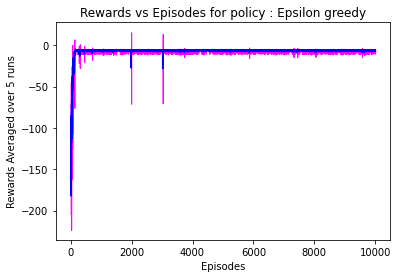

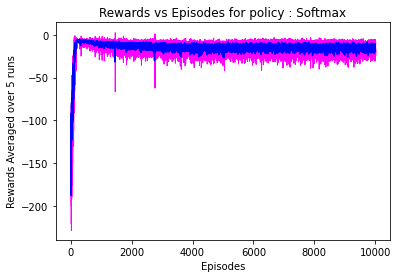

In [ ]:
plot_RC(rewards_per_exp_epsilon7, message = "Epsilon greedy")
plot_RC(rewards_per_exp_tau7, message = "Softmax")

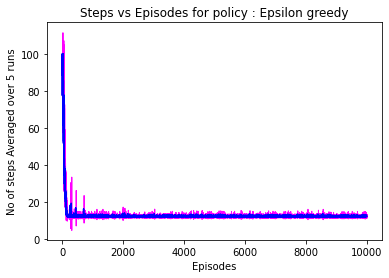

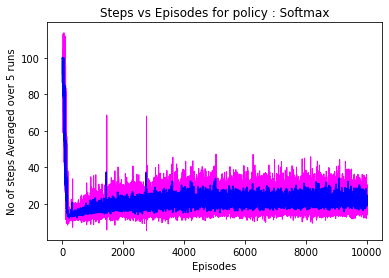

In [ ]:
plot_STEP(steps_per_exp_epsilon7, message = "Epsilon greedy")
plot_STEP(steps_per_exp_tau7, message = "Softmax")

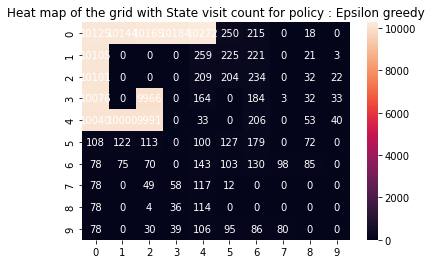

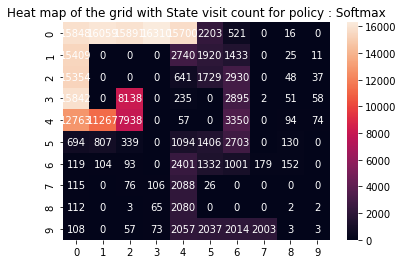

In [ ]:
plot_SVC(avg_state_count_epsilon7, message = "Epsilon greedy")
plot_SVC(avg_state_count_tau7, message = "Softmax")

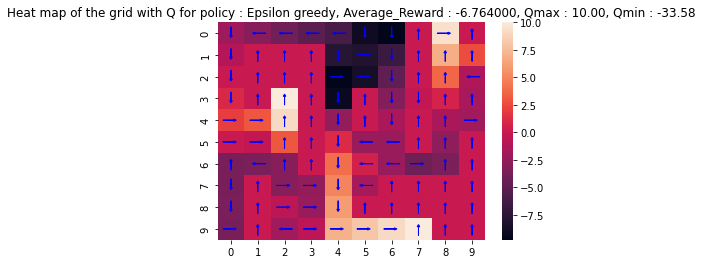

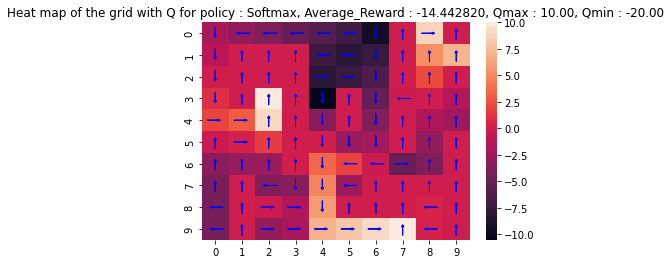

In [ ]:
plot_Q(avg_Q_epsilon7, rewards_per_exp_epsilon7, message = "Epsilon greedy")
plot_Q(avg_Q_tau7, rewards_per_exp_tau7, message = "Softmax")

### 8th Experiment : Q LEARNING
 - Start state : (0, 4)
 - wind : False
 - p = 0.7

In [ ]:
start_state = np.array([[0, 4]])
# create model
gw8 = GridWorld(num_rows = num_rows, num_cols = num_cols, start_state = start_state, goal_states = goal_states, wind = False)
gw8.add_obstructions(obstructed_states = obstructions, bad_states = bad_states, restart_states = restart_states)
gw8.add_rewards(step_reward = - 1, goal_reward = 10, bad_state_reward = - 6, restart_state_reward = - 100)
gw8.add_transition_probability(p_good_transition = 0.7, bias = 0.5)
env8 = gw8.create_gridworld()

#Defining parameters
tau8 = 1.0
epsilon8 = 0.01
alpha_tau8 = 0.2
gamma_tau8 = 1.0
alpha_epsilon8 = 0.2
gamma_epsilon8 = 1.0

In [ ]:
avg_Q_epsilon8, avg_state_count_epsilon8, rewards_per_exp_epsilon8, steps_per_exp_epsilon8 = experiment(gw8, tau8, epsilon8, alpha_epsilon8, gamma_epsilon8, choose_action = choose_action_epsilon_greedy, num_expts = 5, algorithm = qlearning)

The algorithm being applied is : Q LEARNING
The policy being applied is Epsilon greedy
Experiment : 1


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1111.03it/s]


Experiment : 2


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1097.38it/s]


Experiment : 3


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1073.39it/s]


Experiment : 4


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1070.01it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 949.01it/s]


In [ ]:
avg_Q_tau8, avg_state_count_tau8, rewards_per_exp_tau8, steps_per_exp_tau8 = experiment(gw8, tau8, epsilon8, alpha_tau8, gamma_tau8, num_expts = 5, algorithm = qlearning)

The algorithm being applied is : Q LEARNING
The policy being applied is Softmax
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.79it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 246.55it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 271.19it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 256.78it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.93it/s]


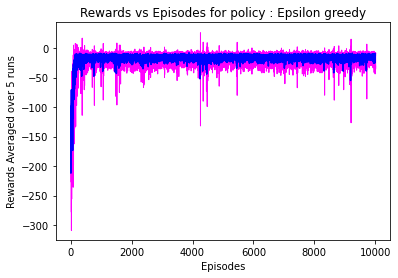

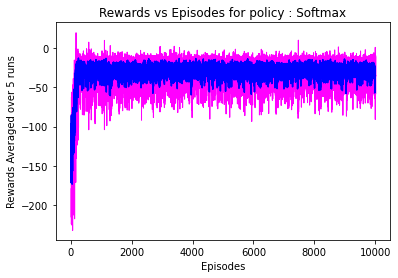

In [ ]:
plot_RC(rewards_per_exp_epsilon8, message = "Epsilon greedy")
plot_RC(rewards_per_exp_tau8, message = "Softmax")

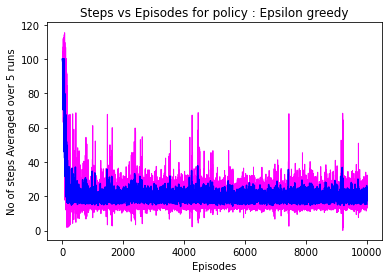

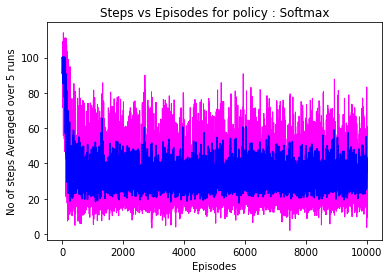

In [ ]:
plot_STEP(steps_per_exp_epsilon8, message = "Epsilon greedy")
plot_STEP(steps_per_exp_tau8, message = "Softmax")

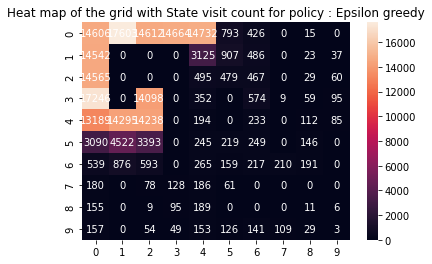

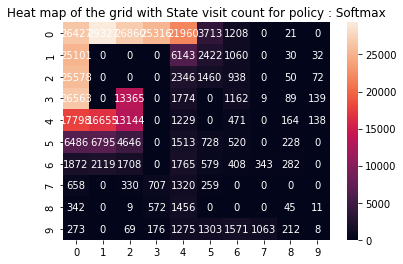

In [ ]:
plot_SVC(avg_state_count_epsilon8, message = "Epsilon greedy")
plot_SVC(avg_state_count_tau8, message = "Softmax")

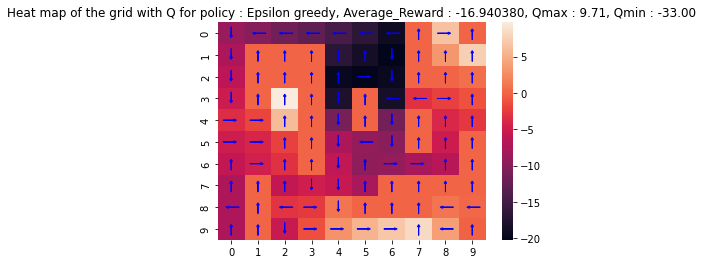

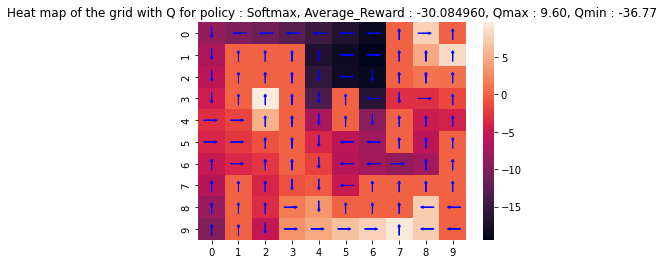

In [ ]:
plot_Q(avg_Q_epsilon8, rewards_per_exp_epsilon8, message = "Epsilon greedy")
plot_Q(avg_Q_tau8, rewards_per_exp_tau8, message = "Softmax")

### 9th Experiment : Q LEARNING
 - Start state : (0, 4)
 - wind : True
 - p = 1.0

In [ ]:
start_state = np.array([[0, 4]])
# create model
gw9 = GridWorld(num_rows = num_rows, num_cols = num_cols, start_state = start_state, goal_states = goal_states, wind = True)
gw9.add_obstructions(obstructed_states = obstructions, bad_states = bad_states, restart_states = restart_states)
gw9.add_rewards(step_reward = - 1, goal_reward = 10, bad_state_reward = - 6, restart_state_reward = - 100)
gw9.add_transition_probability(p_good_transition = 1.0, bias = 0.5)
env9 = gw9.create_gridworld()

#Defining parameters
tau9 = 1.0
epsilon9 = 0.01
alpha_tau9 = 0.1
gamma_tau9 = 1.0
alpha_epsilon9 = 0.2
gamma_epsilon9 = 0.9

In [ ]:
avg_Q_epsilon9, avg_state_count_epsilon9, rewards_per_exp_epsilon9, steps_per_exp_epsilon9 = experiment(gw9, tau9, epsilon9, alpha_epsilon9, gamma_epsilon9, choose_action = choose_action_epsilon_greedy, num_expts = 5, algorithm = qlearning)

The algorithm being applied is : Q LEARNING
The policy being applied is Epsilon greedy
Experiment : 1


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1198.06it/s]


Experiment : 2


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1197.61it/s]


Experiment : 3


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1248.60it/s]


Experiment : 4


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1276.05it/s]


Experiment : 5


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1266.32it/s]


In [ ]:
avg_Q_tau9, avg_state_count_tau9, rewards_per_exp_tau9, steps_per_exp_tau9 = experiment(gw9, tau9, epsilon9, alpha_tau9, gamma_tau9, num_expts = 5, algorithm = qlearning)

The algorithm being applied is : Q LEARNING
The policy being applied is Softmax
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.35it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.62it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.08it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.71it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 312.26it/s]


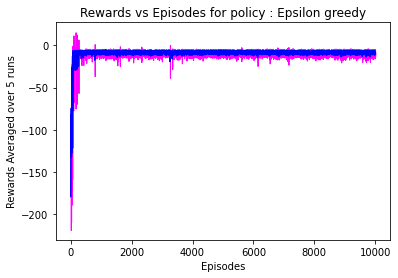

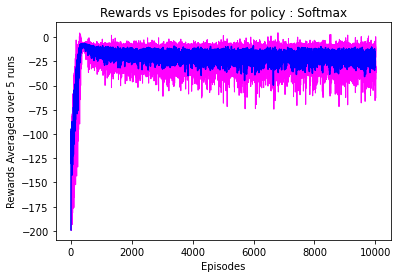

In [ ]:
plot_RC(rewards_per_exp_epsilon9, message = "Epsilon greedy")
plot_RC(rewards_per_exp_tau9, message = "Softmax")

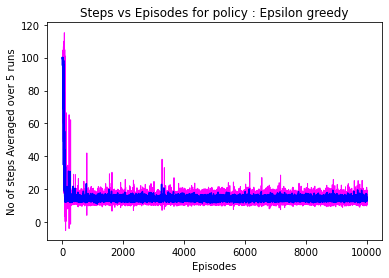

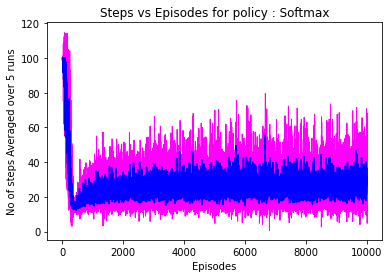

In [ ]:
plot_STEP(steps_per_exp_epsilon9, message = "Epsilon greedy")
plot_STEP(steps_per_exp_tau9, message = "Softmax")

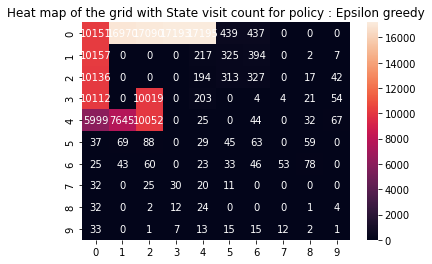

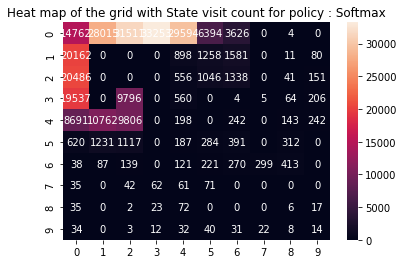

In [ ]:
plot_SVC(avg_state_count_epsilon9, message = "Epsilon greedy")
plot_SVC(avg_state_count_tau9, message = "Softmax")

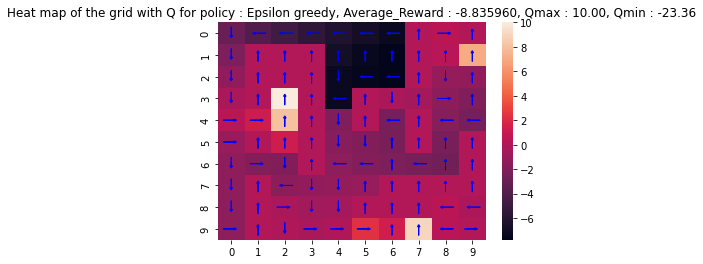

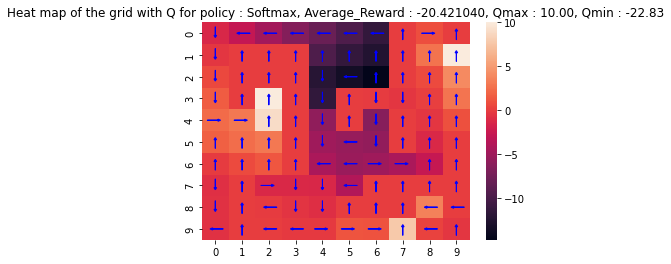

In [ ]:
plot_Q(avg_Q_epsilon9, rewards_per_exp_epsilon9, message = "Epsilon greedy")
plot_Q(avg_Q_tau9, rewards_per_exp_tau9, message = "Softmax")

### 10th Experiment : Q LEARNING
 - Start state : (3, 6)
 - wind : False
 - p = 1.0

In [ ]:
start_state2 = np.array([[3, 6]])
# create model
gw10 = GridWorld(num_rows = num_rows, num_cols = num_cols, start_state = start_state2, goal_states = goal_states, wind = False)
gw10.add_obstructions(obstructed_states = obstructions, bad_states = bad_states, restart_states = restart_states)
gw10.add_rewards(step_reward = - 1, goal_reward = 10, bad_state_reward = - 6, restart_state_reward = - 100)
gw10.add_transition_probability(p_good_transition = 1.0, bias = 0.5)
env10 = gw10.create_gridworld()

#Defining parameters
tau10 = 1.0
epsilon10 = 0.01
alpha_tau10 = 0.2
gamma_tau10 = 1.0
alpha_epsilon10 = 0.2
gamma_epsilon10 = 1.0

In [ ]:
avg_Q_epsilon10, avg_state_count_epsilon10, rewards_per_exp_epsilon10, steps_per_exp_epsilon10 = experiment(gw10, tau10, epsilon10, alpha_epsilon10, gamma_epsilon10, choose_action = choose_action_epsilon_greedy, num_expts = 5, algorithm = qlearning)

The algorithm being applied is : Q LEARNING
The policy being applied is Epsilon greedy
Experiment : 1


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1083.93it/s]


Experiment : 2


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1031.86it/s]


Experiment : 3


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1030.93it/s]


Experiment : 4


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1120.34it/s]


Experiment : 5


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.16it/s]


In [ ]:
avg_Q_tau10, avg_state_count_tau10, rewards_per_exp_tau10, steps_per_exp_tau10 = experiment(gw10, tau10, epsilon10, alpha_tau10, gamma_tau10, num_expts = 5, algorithm = qlearning)

The algorithm being applied is : Q LEARNING
The policy being applied is Softmax
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 479.80it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 485.23it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 460.44it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 496.15it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 460.93it/s]


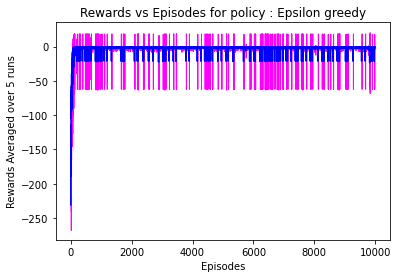

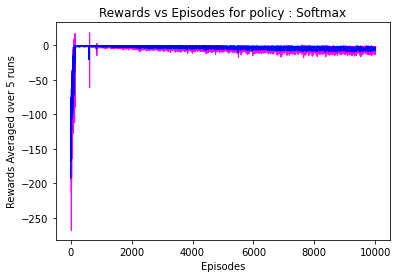

In [ ]:
plot_RC(rewards_per_exp_epsilon10, message = "Epsilon greedy")
plot_RC(rewards_per_exp_tau10, message = "Softmax")

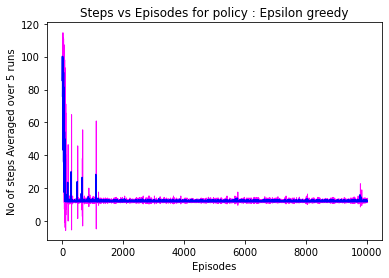

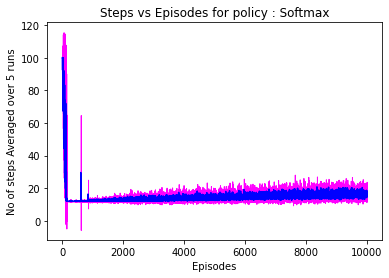

In [ ]:
plot_STEP(steps_per_exp_epsilon10, message = "Epsilon greedy")
plot_STEP(steps_per_exp_tau10, message = "Softmax")

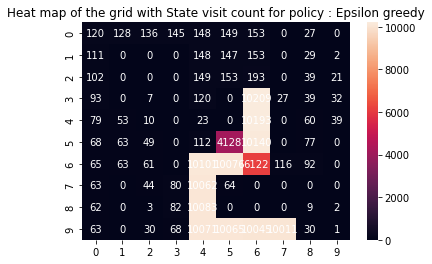

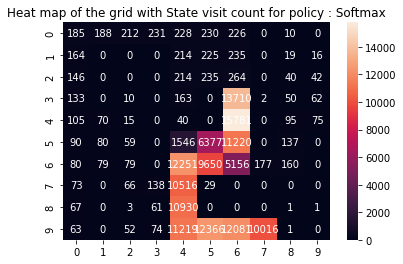

In [ ]:
plot_SVC(avg_state_count_epsilon10, message = "Epsilon greedy")
plot_SVC(avg_state_count_tau10, message = "Softmax")

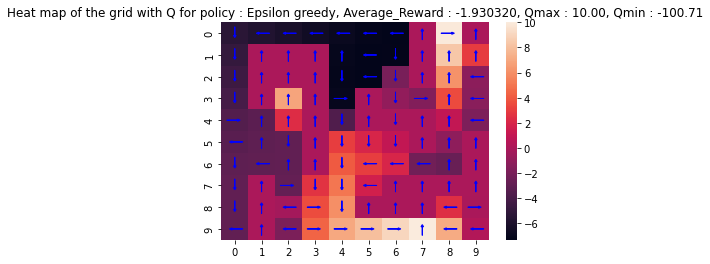

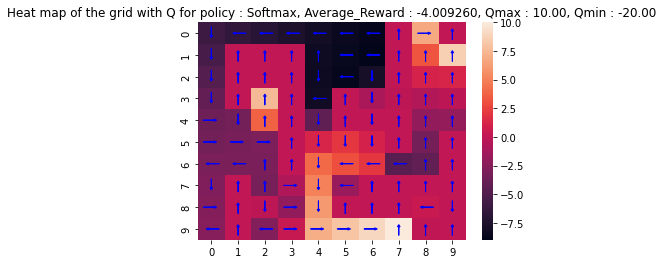

In [ ]:
plot_Q(avg_Q_epsilon10, rewards_per_exp_epsilon10, message = "Epsilon greedy")
plot_Q(avg_Q_tau10, rewards_per_exp_tau10, message = "Softmax")

### 11th Experiment : Q LEARNING
 - Start state : (3, 6)
 - wind : False
 - p = 0.7

In [ ]:
start_state2 = np.array([[3, 6]])
# create model
gw11 = GridWorld(num_rows = num_rows, num_cols = num_cols, start_state = start_state2, goal_states = goal_states, wind = False)
gw11.add_obstructions(obstructed_states = obstructions, bad_states = bad_states, restart_states = restart_states)
gw11.add_rewards(step_reward = - 1, goal_reward = 10, bad_state_reward = - 6, restart_state_reward = - 100)
gw11.add_transition_probability(p_good_transition = 0.7, bias = 0.5)
env11 = gw11.create_gridworld()

#Defining parameters
tau11 = 1.0
epsilon11 = 0.01
alpha_tau11 = 0.2
gamma_tau11 = 1.0
alpha_epsilon11 = 0.2
gamma_epsilon11 = 1.0

In [ ]:
avg_Q_epsilon11, avg_state_count_epsilon11, rewards_per_exp_epsilon11, steps_per_exp_epsilon11 = experiment(gw11, tau11, epsilon11, alpha_epsilon11, gamma_epsilon11, choose_action = choose_action_epsilon_greedy, num_expts = 5, algorithm = qlearning)

The algorithm being applied is : Q LEARNING
The policy being applied is Epsilon greedy
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 655.62it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 634.69it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 691.86it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 699.20it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 726.48it/s]


In [ ]:
avg_Q_tau11, avg_state_count_tau11, rewards_per_exp_tau11, steps_per_exp_tau11 = experiment(gw11, tau11, epsilon11, alpha_tau11, gamma_tau11, num_expts = 5, algorithm = qlearning)

The algorithm being applied is : Q LEARNING
The policy being applied is Softmax
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 213.81it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 231.96it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 244.14it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 230.78it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 243.53it/s]


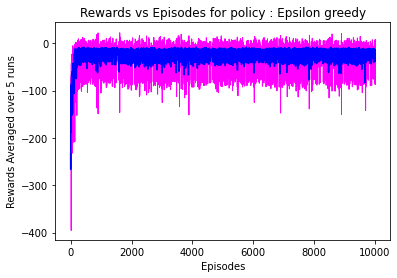

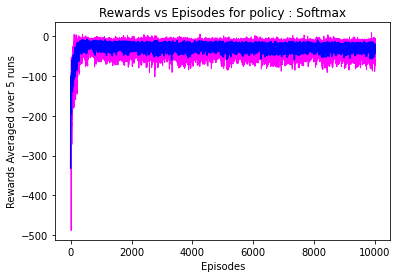

In [ ]:
plot_RC(rewards_per_exp_epsilon11, message = "Epsilon greedy")
plot_RC(rewards_per_exp_tau11, message = "Softmax")

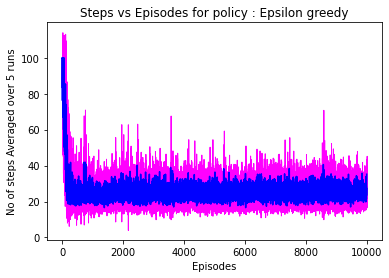

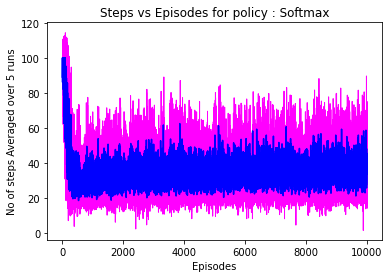

In [ ]:
plot_STEP(steps_per_exp_epsilon11, message = "Epsilon greedy")
plot_STEP(steps_per_exp_tau11, message = "Softmax")

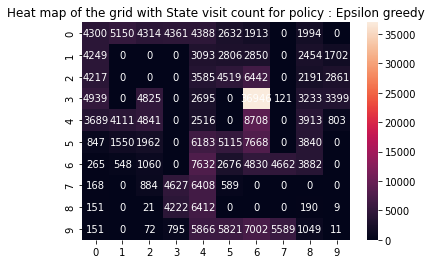

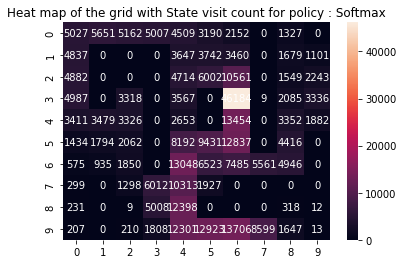

In [ ]:
plot_SVC(avg_state_count_epsilon11, message = "Epsilon greedy")
plot_SVC(avg_state_count_tau11, message = "Softmax")

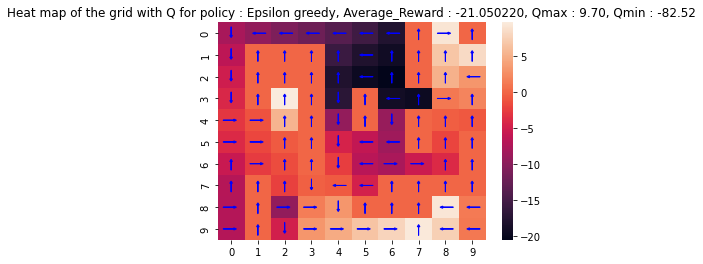

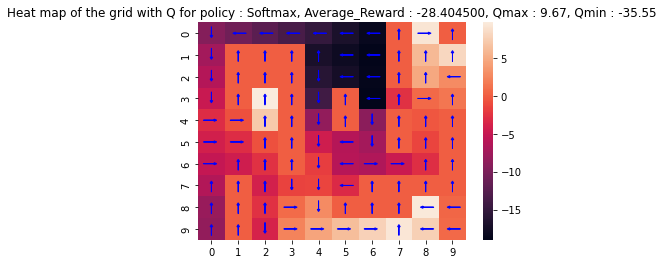

In [ ]:
plot_Q(avg_Q_epsilon11, rewards_per_exp_epsilon11, message = "Epsilon greedy")
plot_Q(avg_Q_tau11, rewards_per_exp_tau11, message = "Softmax")

### 12th Experiment : Q LEARNING
 - Start state : (3, 6)
 - wind : True
 - p = 1.0

In [ ]:
start_state2 = np.array([[3, 6]])
# create model
gw12 = GridWorld(num_rows = num_rows, num_cols = num_cols, start_state = start_state2, goal_states = goal_states, wind = True)
gw12.add_obstructions(obstructed_states = obstructions, bad_states = bad_states, restart_states = restart_states)
gw12.add_rewards(step_reward = - 1, goal_reward = 10, bad_state_reward = - 6, restart_state_reward = - 100)
gw12.add_transition_probability(p_good_transition = 1.0, bias = 0.5)
env12 = gw12.create_gridworld()

#Defining parameters
tau12 = 1.0
epsilon12 = 0.01
alpha_tau12 = 0.1
gamma_tau12 = 1.0
alpha_epsilon12 = 0.2
gamma_epsilon12 = 0.9

In [ ]:
avg_Q_epsilon12, avg_state_count_epsilon12, rewards_per_exp_epsilon12, steps_per_exp_epsilon12 = experiment(gw12, tau12, epsilon12, alpha_epsilon12, gamma_epsilon12, choose_action = choose_action_epsilon_greedy, num_expts = 5, algorithm = qlearning)

The algorithm being applied is : Q LEARNING
The policy being applied is Epsilon greedy
Experiment : 1


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1349.68it/s]


Experiment : 2


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1227.87it/s]


Experiment : 3


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1293.19it/s]


Experiment : 4


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1266.28it/s]


Experiment : 5


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1198.45it/s]


In [ ]:
avg_Q_tau12, avg_state_count_tau12, rewards_per_exp_tau12, steps_per_exp_tau12 = experiment(gw12, tau12, epsilon12, alpha_tau12, gamma_tau12, num_expts = 5, algorithm = qlearning)

The algorithm being applied is : Q LEARNING
The policy being applied is Softmax
Experiment : 1


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.78it/s]


Experiment : 2


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.12it/s]


Experiment : 3


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.88it/s]


Experiment : 4


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.75it/s]


Experiment : 5


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.96it/s]


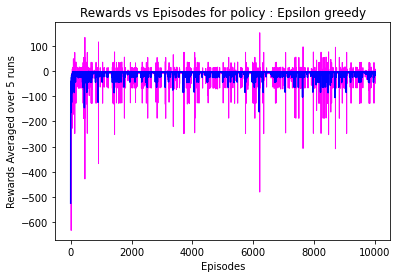

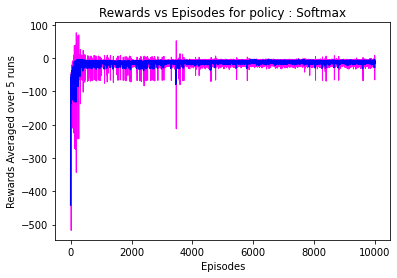

In [ ]:
plot_RC(rewards_per_exp_epsilon12, message = "Epsilon greedy")
plot_RC(rewards_per_exp_tau12, message = "Softmax")

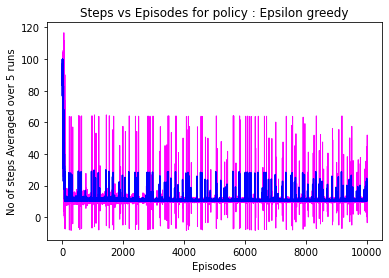

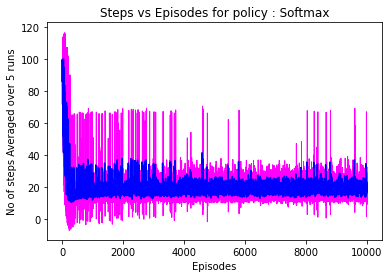

In [ ]:
plot_STEP(steps_per_exp_epsilon12, message = "Epsilon greedy")
plot_STEP(steps_per_exp_tau12, message = "Softmax")

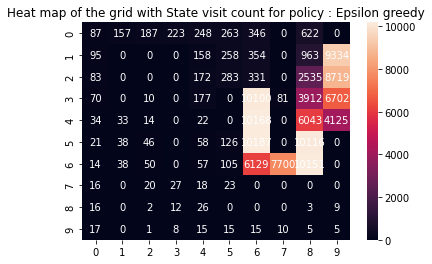

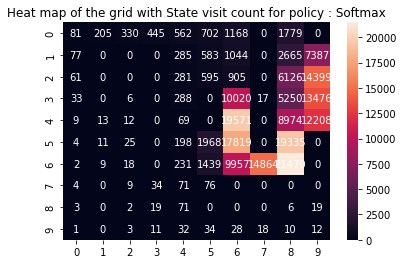

In [ ]:
plot_SVC(avg_state_count_epsilon12, message = "Epsilon greedy")
plot_SVC(avg_state_count_tau12, message = "Softmax")

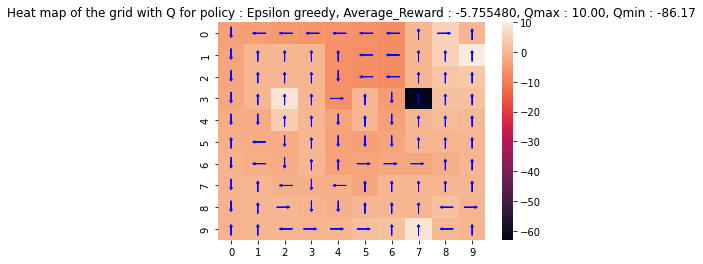

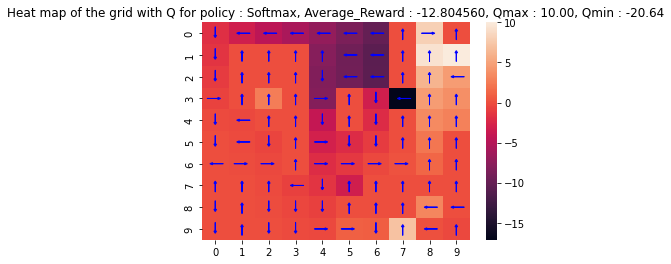

In [ ]:
plot_Q(avg_Q_epsilon12, rewards_per_exp_epsilon12, message = "Epsilon greedy")
plot_Q(avg_Q_tau12, rewards_per_exp_tau12, message = "Softmax")